In [17]:
!mkdir images/

mkdir: cannot create directory ‘images/’: File exists


In [18]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Sequential, Model
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam
import matplotlib.pyplot as plt
import numpy as np

In [19]:
IMG_ROWS = 28
IMG_COLS = 28
CHANNELS = 1
IMAGE_SHAPE = (IMG_ROWS, IMG_COLS, CHANNELS)

In [20]:
def build_discriminator():
    
    model = Sequential()
    
    model.add(Flatten(input_shape=IMAGE_SHAPE))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    
    img = Input(shape=IMAGE_SHAPE)
    validity = model(img)
    
    return Model(img, validity)

In [21]:
def build_generator():
    NOISE_SHAPE = (100, )
    
    model = Sequential()
    
    model.add(Dense(256, input_shape=NOISE_SHAPE))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(IMAGE_SHAPE), activation='tanh'))
    model.add(Reshape(IMAGE_SHAPE))
    
    model.summary()
    
    noise = Input(shape=NOISE_SHAPE)
    img = model(noise)
    
    return Model(noise, img)

In [22]:
def train(epochs, batch_size=128, save_interval=50):
    
    (X_train, _), (_, _) = mnist.load_data()
    
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    
    X_train = np.expand_dims(X_train, axis=3)
    
    half_batch = int(batch_size / 2)
    
    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]
        
        noise = np.random.normal(0, 1, (half_batch, 100)) # fake data
        
        gen_imgs = generator.predict(noise, verbose=0)
        
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
        
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        noise = np.random.normal(0, 1, (batch_size, 100))
        
        valid_y = np.array([1]* batch_size)
        
        g_loss = combined.train_on_batch(noise, valid_y)
        
        if epoch % 100 == 0:
            print(f"\nEpoch {epoch}: [D Loss: {d_loss[0]}] [G Loss: {g_loss}]")
        
        if epoch % save_interval == 0:
            save_imgs(epoch)

In [23]:
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise, verbose=0)
    
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    fig.savefig(f"/kaggle/working/images/mnist_{epoch}.png")
    plt.close()

In [24]:
optimizer = Adam(0.0002, 0.5)

discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

z = Input(shape=(100,))
img = generator(z)

discriminator.trainable = False

valid = discriminator(img)

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

train(epochs=6000, batch_size=32, save_interval=200)

generator.save('generator_model_test.h5')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_14 (Dense)            (None, 512)               401920    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 256)               131328    
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 533,505
Non-tr

In [26]:
from tensorflow.keras.models import load_model
from numpy import asarray
from matplotlib import pyplot
from numpy.random import randn

In [27]:
model = load_model('/kaggle/working/generator_model_test.h5')

1/1 [==============================] - 0s 26ms/step


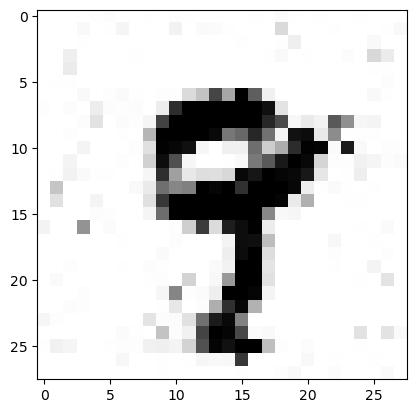

In [33]:
vector = randn(100)
vector = vector.reshape(1, 100)

X = model.predict(vector)

pyplot.imshow(X[0, :, :, 0], cmap='gray_r')
pyplot.show()